### Considered model: four-bar linkage (= two link manipulator + one link manipulator + rigid coupling)


This Notebook depends on symbtools >=0.2.5

→ `pip install --upgrade symbtools`





In [2]:
%load_ext ipydex.displaytools
%matplotlib inline

import sys
# to load assimulo under wsl2
sys.path.append('/home/kwrede/miniconda3/lib/python3.8/site-packages')
sys.path.append('/home/wredi/miniconda3/lib/python3.8/site-packages')

import os
import sympy as sp
import numpy as npy  # we need `np` later 
from sympy import sin, cos, pi
from sympy.interactive import printing

# using wredsen's symbtools fork (https://github.com/wredsen/symbtools @ DAE_statefeedback), assuming repos SA-Wrede and symbtools share the same parent directory
sys.path.append('../../symbtools/')
import symbtools as st
import symbtools.modeltools as mt
from symbtools.modeltools import Rz # Rotationsmatrix in the xy plane (c, -s; s, c)

import scipy.integrate as sc_integrate
from scipy.optimize import fmin
import matplotlib.pyplot as pl
from assimulo.solvers import ODASSL as SOLVER # Imports the solver ODASSL from Assimulo
from assimulo.problem import Overdetermined_Problem # Imports the problem formulation from Assimulo
import ipydex
plt = pl

printing.init_printing(1)

The ipydex.displaytools extension is already loaded. To reload it, use:
  %reload_ext ipydex.displaytools


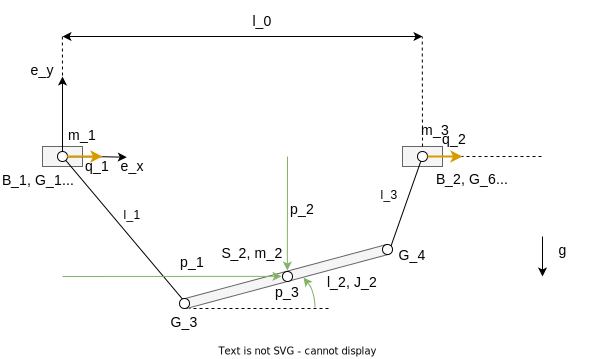

In [3]:
from IPython.display import Image
from IPython.core.display import SVG
SVG(filename='ODE_flatness_analysis_simulation_diagram.svg')

In [4]:
t = sp.Symbol('t')  # time variable

# coordinates
np = 3 # number of passive coordinates (not directly actuated)
nq = 2 # number of actuated coordinates
n = np + nq

pp = st.symb_vector("p1:{0}".format(np+1)) # vector of passive coordinates
qq = st.symb_vector("q1:{0}".format(nq+1)) # vector of actuated coordinates



# vector of control inputs
aa = st.symb_vector("a1:{0}".format(4+1)) ##:T
# vector of all coordinates
ttheta = st.row_stack(pp, qq) ##:T
# vector of velocities 
tthetad = st.time_deriv(ttheta, ttheta) ##:T
# vector of accelerations
tthetadd = st.time_deriv(ttheta, ttheta, order=2) ##:T

st.make_global(ttheta, tthetad, tthetadd)

QQ = st.symb_vector("Q1:{0}".format(n+1)) ##:T # vector of generalized foces
st.make_global(QQ)

aa.T := [a₁  a₂  a₃  a₄]

---

ttheta.T := [p₁  p₂  p₃  q₁  q₂]

---

tthetad.T := [ṗ₁  ṗ₂  ṗ₃  q̇₁  q̇₂]

---

tthetadd.T := [p̈₁  p̈₂  p̈₃  q̈₁  q̈₂]

---

QQ.T := [Q₁  Q₂  Q₃  Q₄  Q₅]

---

In [5]:
# symbols for analytic equations
params = sp.symbols('s2, m1, m2, m3, J1, J2, J3, mc1b, mc2b d1, d4, l0, l1, l2, l3, g')
st.make_global(params)

# symbols for control inputs
# ttau = sp.symbols('tau')
tau1, tau2, tau3, tau4 = ttau = st.symb_vector("tau1, tau2, tau3, tau4")


Specify the geometry (joints G and centers of masses S)

In [8]:
# unit vectors
ex = sp.Matrix([1, 0])
ey = sp.Matrix([0, 1])

# basis 1 and 2 (cart positions)
S1 = G1 = B1 = sp.Matrix([q1, 0]) ##:
S3 = G6 = B2 = sp.Matrix([l0 + q2, 0]) ##:

# center of gravity of load
S2 = sp.Matrix([p1, p2])

# suspension points of load
G3 = S2 - Rz(p3)*ex*s2 ##:
G4 = S2 + Rz(p3)*ex*s2 ##:

# Time derivatives of centers of masses
Sd1, Sd2, Sd3 = st.col_split(st.time_deriv(st.col_stack(S1, S2, S3), ttheta)) ##:

B1 := ⎡q₁⎤
⎢  ⎥
⎣0 ⎦

---

B2 := ⎡l₀ + q₂⎤
⎢       ⎥
⎣   0   ⎦

---

G3 := ⎡p₁ - s₂⋅cos(p₃)⎤
⎢               ⎥
⎣p₂ - s₂⋅sin(p₃)⎦

---

G4 := ⎡p₁ + s₂⋅cos(p₃)⎤
⎢               ⎥
⎣p₂ + s₂⋅sin(p₃)⎦

---

(Sd1, Sd2, Sd3) := ⎛⎡q̇₁⎤  ⎡ṗ₁⎤  ⎡q̇₂⎤⎞
⎜⎢  ⎥, ⎢  ⎥, ⎢  ⎥⎟
⎝⎣0 ⎦  ⎣ṗ₂⎦  ⎣0 ⎦⎠

---

In [9]:
# kinetic energy
T1 = (m1/2 * Sd1.T*Sd1)[0] 
T2 = (m2/2 * Sd2.T*Sd2)[0] + J2/2 * (pdot3)**2
T3 = (m3/2 * Sd3.T*Sd3)[0]

T = T1 + T2 + T3 ##:

# potential energy, for l1 <= l2
V = m2*g*S2[1] ##:

---

---

this model is very easy ...

In [10]:

mod = mt.generate_symbolic_model(T, V, ttheta, QQ)
mod.eqns

⎡   -Q₁ + m₂⋅p̈₁    ⎤
⎢                  ⎥
⎢-Q₂ + g⋅m₂ + m₂⋅p̈₂⎥
⎢                  ⎥
⎢    J₂⋅p̈₃ - Q₃    ⎥
⎢                  ⎥
⎢   -Q₄ + m₁⋅q̈₁    ⎥
⎢                  ⎥
⎣   -Q₅ + m₃⋅q̈₂    ⎦

... but $Q_i$ are yet unknown → calculate them via the principle of virtual work, see e.g. [Wikipedia](https://en.wikipedia.org/wiki/Generalized_forces#Virtual_work):
$$
\delta W = \sum_{i=1}^n \mathbf {F}_{i} \cdot \frac {\partial \mathbf {r}_i} {\partial q_1} \delta q_1 +\ldots + \sum_{i=1}^n \mathbf {F}_{i} \cdot \frac {\partial \mathbf {r}_i} {\partial q_m} \delta q_m.
$$

- $ \mathbf {F}_{i}$ applied forces, i.e.  $i=1,2$ → cart-forces, $i=3,4$ → rope-foces
- $ \mathbf {r}_{i}$ position vectors of each particle (along the direction of forces): $i=1,3$ → cart, $i=2$ → load
- $ \mathbf {\delta r}_{i}$ virtual displacement
- $ \mathbf \delta q_{j} = \delta \theta_{j}$ virtual displacement of generalized coordinates


The virtual work of a system of particles can be written in the form

$$
    \delta W = Q_1\delta q_1 + \ldots + Q_m\delta q_m,
$$
where

$$
    Q_j = \sum_{i=1}^n \frac {\partial \mathbf {r}_i} {\partial q_j} \cdot \mathbf {F}_{i}  ,\quad j=1,\ldots, m, 
$$

In [11]:
F1 = sp.Matrix([tau1, 0])  ##:T
F2 = sp.Matrix([tau2, 0])  ##:T

# unit vectors for ropes to split forces according to angles
rope1 = (G3 - S1)
rope2 = (G4 - S3)
uv_rope1 = rope1/sp.sqrt((rope1.T*rope1)[0])
uv_rope2 = rope2/sp.sqrt((rope2.T*rope2)[0])

# simplify expressions by using l1, l2 as shortcuts 
uv_rope1 = rope1/l1
uv_rope2 = rope2/l2

F3 = uv_rope1 * tau3 ##:
F4 = uv_rope2 * tau4 ##:

F1.T := [τ₁  0]

---

F2.T := [τ₂  0]

---

F3 := ⎡τ₃⋅(p₁ - q₁ - s₂⋅cos(p₃))⎤
⎢─────────────────────────⎥
⎢            l₁           ⎥
⎢                         ⎥
⎢  τ₃⋅(p₂ - s₂⋅sin(p₃))   ⎥
⎢  ────────────────────   ⎥
⎣           l₁            ⎦

---

F4 := ⎡τ₄⋅(-l₀ + p₁ - q₂ + s₂⋅cos(p₃))⎤
⎢───────────────────────────────⎥
⎢               l₂              ⎥
⎢                               ⎥
⎢     τ₄⋅(p₂ + s₂⋅sin(p₃))      ⎥
⎢     ────────────────────      ⎥
⎣              l₂               ⎦

---

In [12]:
dt1, dt2, dt3, dt4, dt5 = ddelta_theta = st.symb_vector(f"\\delta\\theta_1:{n+1}") ##:

ddelta_theta := ⎡\delta\theta₁⎤
⎢             ⎥
⎢\delta\theta₂⎥
⎢             ⎥
⎢\delta\theta₃⎥
⎢             ⎥
⎢\delta\theta₄⎥
⎢             ⎥
⎣\delta\theta₅⎦

---

In [13]:
ttheta

⎡p₁⎤
⎢  ⎥
⎢p₂⎥
⎢  ⎥
⎢p₃⎥
⎢  ⎥
⎢q₁⎥
⎢  ⎥
⎣q₂⎦

In [14]:
delta_S1 = S1*0
delta_S3 = S3*0

delta_G3 = G3*0 
delta_G4 = G4*0



for theta, delta_theta in zip(ttheta, ddelta_theta):
    
    delta_S1 += S1.diff(theta)*delta_theta
    delta_S3 += S3.diff(theta)*delta_theta
    
    delta_G3 += G3.diff(theta)*delta_theta
    delta_G4 += G4.diff(theta)*delta_theta
    
delta_S1 ##:
delta_S3 ##:

delta_G3 ##:
delta_G4 ##:

(delta_S1) := ⎡\delta\theta₄⎤
⎢             ⎥
⎣      0      ⎦

---

(delta_S3) := ⎡\delta\theta₅⎤
⎢             ⎥
⎣      0      ⎦

---

(delta_G3) := ⎡\delta\theta₁ + \delta\theta₃⋅s₂⋅sin(p₃)⎤
⎢                                        ⎥
⎣\delta\theta₂ - \delta\theta₃⋅s₂⋅cos(p₃)⎦

---

(delta_G4) := ⎡\delta\theta₁ - \delta\theta₃⋅s₂⋅sin(p₃)⎤
⎢                                        ⎥
⎣\delta\theta₂ + \delta\theta₃⋅s₂⋅cos(p₃)⎦

---

In [15]:
# simple part (carts)
delta_W = delta_S1.T*F1 + delta_S3.T*F2 ##:

# rope1 (F3 > 0 means rope is pushing from S1 towards G3)
delta_W = delta_W + delta_G3.T*F3 - delta_S1.T*F3 ##:

# rope2 (F4 > 0 means rope is pushing from S3 towards G4)
delta_W = delta_W + delta_G4.T*F4 - delta_S3.T*F4 ##:

# convert from 1x1 Matrix to scalar:
# delta_W = delta_W[0, 0] ##:

delta_W := [\delta\theta₄⋅τ₁ + \delta\theta₅⋅τ₂]

---

delta_W := ⎡                   \delta\theta₄⋅τ₃⋅(p₁ - q₁ - s₂⋅cos(p₃))                   
⎢\delta\theta₄⋅τ₁ - ─────────────────────────────────────── + \delta\theta₅⋅τ₂
⎣                                      l₁                                     

   τ₃⋅(\delta\theta₁ + \delta\theta₃⋅s₂⋅sin(p₃))⋅(p₁ - q₁ - s₂⋅cos(p₃))   τ₃⋅(
 + ──────────────────────────────────────────────────────────────────── + ────
                                    l₁                                        

\delta\theta₂ - \delta\theta₃⋅s₂⋅cos(p₃))⋅(p₂ - s₂⋅sin(p₃))⎤
───────────────────────────────────────────────────────────⎥
                           l₁                              ⎦

---

delta_W := ⎡                   \delta\theta₄⋅τ₃⋅(p₁ - q₁ - s₂⋅cos(p₃))                   
⎢\delta\theta₄⋅τ₁ - ─────────────────────────────────────── + \delta\theta₅⋅τ₂
⎣                                      l₁                                     

   \delta\theta₅⋅τ₄⋅(-l₀ + p₁ - q₂ + s₂⋅cos(p₃))   τ₄⋅(\delta\theta₁ - \delta\
 - ───────────────────────────────────────────── + ───────────────────────────
                         l₂                                                   

theta₃⋅s₂⋅sin(p₃))⋅(-l₀ + p₁ - q₂ + s₂⋅cos(p₃))   τ₄⋅(\delta\theta₂ + \delta\t
─────────────────────────────────────────────── + ────────────────────────────
         l₂                                                                   

heta₃⋅s₂⋅cos(p₃))⋅(p₂ + s₂⋅sin(p₃))   τ₃⋅(\delta\theta₁ + \delta\theta₃⋅s₂⋅sin
─────────────────────────────────── + ────────────────────────────────────────
   l₂                                                                  l₁     

(p₃))⋅(p₁ - q₁ - s₂⋅cos(p₃))   τ₃⋅(\d

---

In [16]:
QQ_expr = delta_W.jacobian(ddelta_theta).T ##:

QQ_expr := ⎡                                             τ₄⋅(-l₀ + p₁ - q₂ + s₂⋅cos(p₃)) 
⎢                                             ─────────────────────────────── 
⎢                                                            l₂               
⎢                                                                             
⎢                                                     τ₄⋅(p₂ + s₂⋅sin(p₃))   τ
⎢                                                     ──────────────────── + ─
⎢                                                              l₂             
⎢                                                                             
⎢s₂⋅τ₄⋅(p₂ + s₂⋅sin(p₃))⋅cos(p₃)   s₂⋅τ₄⋅(-l₀ + p₁ - q₂ + s₂⋅cos(p₃))⋅sin(p₃) 
⎢─────────────────────────────── - ────────────────────────────────────────── 
⎢               l₂                                     l₂                     
⎢                                                                             
⎢                                        

---

In [17]:
mod.eqns

⎡   -Q₁ + m₂⋅p̈₁    ⎤
⎢                  ⎥
⎢-Q₂ + g⋅m₂ + m₂⋅p̈₂⎥
⎢                  ⎥
⎢    J₂⋅p̈₃ - Q₃    ⎥
⎢                  ⎥
⎢   -Q₄ + m₁⋅q̈₁    ⎥
⎢                  ⎥
⎣   -Q₅ + m₃⋅q̈₂    ⎦

In [74]:
eqns = mod.eqns.subz(QQ, QQ_expr) ##:

eqns := ⎡                                                                           τ₃
⎢                                                       m₂⋅p̈₁ - ─────────────
⎢                                                                  ___________
⎢                                                                 ╱           
⎢                                                               ╲╱  (p₂ - s₂⋅s
⎢                                                                             
⎢                                                                             
⎢                                                   g⋅m₂ + m₂⋅p̈₂ - ──────────
⎢                                                                     ________
⎢                                                                    ╱        
⎢                                                                  ╲╱  (p₂ - s
⎢                                                                             
⎢                 s₂⋅τ₃⋅(p₂ - s₂⋅sin(p₃))⋅co

---

In [19]:
eqns.jacobian(ttau)

⎡                            -(p₁ - q₁ - s₂⋅cos(p₃))                          
⎢0   0                       ────────────────────────                         
⎢                                       l₁                                    
⎢                                                                             
⎢                              -(p₂ - s₂⋅sin(p₃))                             
⎢0   0                         ───────────────────                            
⎢                                       l₁                                    
⎢                                                                             
⎢        s₂⋅(p₂ - s₂⋅sin(p₃))⋅cos(p₃)   s₂⋅(p₁ - q₁ - s₂⋅cos(p₃))⋅sin(p₃)    s
⎢0   0   ──────────────────────────── - ─────────────────────────────────  - ─
⎢                     l₁                                l₁                    
⎢                                                                             
⎢                              p₁ - q₁ - s₂⋅cos(p₃) 

In [20]:
# eliminate the last two equations and tau1,2 → 3 remaining

In [21]:
eqns1 = eqns[:-2, :] ##:

eqns1 := ⎡                                                     τ₄⋅(-l₀ + p₁ - q₂ + s₂⋅c
⎢                                             m₂⋅p̈₁ - ───────────────────────
⎢                                                                    l₂       
⎢                                                                             
⎢                                                                τ₄⋅(p₂ + s₂⋅s
⎢                                                 g⋅m₂ + m₂⋅p̈₂ - ────────────
⎢                                                                         l₂  
⎢                                                                             
⎢        s₂⋅τ₄⋅(p₂ + s₂⋅sin(p₃))⋅cos(p₃)   s₂⋅τ₄⋅(-l₀ + p₁ - q₂ + s₂⋅cos(p₃))⋅
⎢J₂⋅p̈₃ - ─────────────────────────────── + ──────────────────────────────────
⎣                       l₂                                     l₂             

os(p₃))   τ₃⋅(p₁ - q₁ - s₂⋅cos(p₃))                                           
──────── - ─────────────────────────      

---

In [22]:
# TODO: Warum können tau1,2 eliminiert werden, Zshg. zu eqns erste beiden Spalten?
ttau1 = ttau[2:, :] ##:

ttau1 := ⎡τ₃⎤
⎢  ⎥
⎣τ₄⎦

---

now we have two inputs distributed over three equations. The $3\times 2$ coefficient matrix $B_1$ is the following:

In [23]:
B1 = eqns1.jacobian(ttau1) ##:

B1 := ⎡                    -(p₁ - q₁ - s₂⋅cos(p₃))                                  
⎢                    ────────────────────────                                 
⎢                               l₁                                            
⎢                                                                             
⎢                      -(p₂ - s₂⋅sin(p₃))                                     
⎢                      ───────────────────                                    
⎢                               l₁                                            
⎢                                                                             
⎢s₂⋅(p₂ - s₂⋅sin(p₃))⋅cos(p₃)   s₂⋅(p₁ - q₁ - s₂⋅cos(p₃))⋅sin(p₃)    s₂⋅(p₂ + 
⎢──────────────────────────── - ─────────────────────────────────  - ─────────
⎣             l₁                                l₁                            

          -(-l₀ + p₁ - q₂ + s₂⋅cos(p₃))                      ⎤
          ──────────────────────────────                     

---

We need its left pseudoinverse, i.e. the $2 \times 3$ matrix $B_1^{L+}$ with $B_1^{L+} B_1 = I_2$ and its left Orthocomplement $B_1^{L\perp}$ ($1 \times 3$) with $B_1^{L\perp} B_1 = 0_{1 \times 2}$

Note: both matrices are not unique: There are infinitely many Pseudoinverses and Othocomplements.

In [24]:
B1pinv = B1[:2, :].inverse_ADJ() # this is 2 x 2
B1pinv = st.col_stack(B1pinv, sp.Matrix([0, 0])) ##:

B1pinv.shape ##:

B1pinv := ⎡                                              ⎛  p₂   s₂⋅sin(p₃)⎞            
⎢                                        l₁⋅l₂⋅⎜- ── - ──────────⎟            
⎢                                              ⎝  l₂       l₂    ⎠            
⎢─────────────────────────────────────────────────────────────────────────────
⎢l₀⋅p₂ - l₀⋅s₂⋅sin(p₃) + 2⋅p₁⋅s₂⋅sin(p₃) - p₂⋅q₁ + p₂⋅q₂ - 2⋅p₂⋅s₂⋅cos(p₃) - q
⎢                                                                             
⎢                                               ⎛p₂   s₂⋅sin(p₃)⎞             
⎢                                         l₁⋅l₂⋅⎜── - ──────────⎟             
⎢                                               ⎝l₁       l₁    ⎠             
⎢─────────────────────────────────────────────────────────────────────────────
⎣l₀⋅p₂ - l₀⋅s₂⋅sin(p₃) + 2⋅p₁⋅s₂⋅sin(p₃) - p₂⋅q₁ + p₂⋅q₂ - 2⋅p₂⋅s₂⋅cos(p₃) - q

                                                                              
                                         

---

---

In [25]:
# check
tmp = (B1pinv * B1).smplf ##:


assert tmp == sp.eye(2)

tmp := ⎡1  0⎤
⎢    ⎥
⎣0  1⎦

---

In [26]:
# nullspace(~kernel) (orthocomplement)

A = st.symbMatrix(3, 2)##:

A := ⎡a₁₁  a₁₂⎤
⎢        ⎥
⎢a₂₁  a₂₂⎥
⎢        ⎥
⎣a₃₁  a₃₂⎦

---

In [27]:
A_ortho = st.nullspaceMatrix(A.T).T ##:

A_ortho := [a₂₁⋅a₃₂ - a₂₂⋅a₃₁  -a₁₁⋅a₃₂ + a₁₂⋅a₃₁  a₁₁⋅a₂₂ - a₁₂⋅a₂₁]

---

In [28]:
# check

(A.T * A_ortho.T).smplf

⎡0⎤
⎢ ⎥
⎣0⎦

In [29]:
# TODO: Was passiert hier genau bzw. wieso?
B1_ortho = A_ortho.subz(list(A), list(B1)).smplf*l1*l2 ##:

B1_ortho := ⎡   ⎛                         2                             2                 
⎣s₂⋅⎝l₀⋅p₂⋅sin(p₃) - l₀⋅s₂⋅sin (p₃) - 2⋅p₁⋅p₂⋅sin(p₃) + 2⋅p₂ ⋅cos(p₃) + p₂⋅q₁⋅

                                   2                2    ⎞                    
sin(p₃) + p₂⋅q₂⋅sin(p₃) + q₁⋅s₂⋅sin (p₃) - q₂⋅s₂⋅sin (p₃)⎠  s₂⋅((-p₁ + q₁ + s₂

                                                                              
⋅cos(p₃))⋅(l₀⋅sin(p₃) - p₁⋅sin(p₃) + p₂⋅cos(p₃) + q₂⋅sin(p₃)) + (-p₁⋅sin(p₃) +

                                                                              
 p₂⋅cos(p₃) + q₁⋅sin(p₃))⋅(l₀ - p₁ + q₂ - s₂⋅cos(p₃)))  (p₂ - s₂⋅sin(p₃))⋅(l₀ 

                                                                   ⎤
- p₁ + q₂ - s₂⋅cos(p₃)) - (p₂ + s₂⋅sin(p₃))⋅(-p₁ + q₁ + s₂⋅cos(p₃))⎦

---

In [30]:
# check orthocomplement property:
res = (B1_ortho * B1).smplf ##:
assert not any(res)

res := [0  0]

---

Now we can assemble the $3\times 3$ transformation matrix:

$$
W_1 = 
\left(\begin{matrix}
B_1^{L+} \\
B_1^{L\perp}
\end{matrix} \right)
$$

In [31]:
W1 = st.row_stack(B1pinv, B1_ortho) ##:i

info(W1) := "<class 'sympy.matrices.dense.MutableDenseMatrix'> with count_ops: Matrix([[37, 36, 0], [36, 34, 0], [38, 33, 19]])"

---

In [32]:
W1

⎡                                                             ⎛  p₂   s₂⋅sin(p
⎢                                                       l₁⋅l₂⋅⎜- ── - ────────
⎢                                                             ⎝  l₂       l₂  
⎢               ──────────────────────────────────────────────────────────────
⎢               l₀⋅p₂ - l₀⋅s₂⋅sin(p₃) + 2⋅p₁⋅s₂⋅sin(p₃) - p₂⋅q₁ + p₂⋅q₂ - 2⋅p₂
⎢                                                                             
⎢                                                              ⎛p₂   s₂⋅sin(p₃
⎢                                                        l₁⋅l₂⋅⎜── - ─────────
⎢                                                              ⎝l₁       l₁   
⎢               ──────────────────────────────────────────────────────────────
⎢               l₀⋅p₂ - l₀⋅s₂⋅sin(p₃) + 2⋅p₁⋅s₂⋅sin(p₃) - p₂⋅q₁ + p₂⋅q₂ - 2⋅p₂
⎢                                                                             
⎢   ⎛                         2                     

In [33]:
eqns2 = (W1*eqns1).smplf ##:

eqns2 := ⎡                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢s₂⋅((-p₁ + q₁ + s₂⋅cos(p₃))⋅(l₀⋅sin(p₃) - p₁⋅sin(p₃) + p₂⋅cos(p₃) + q₂⋅sin(p₃
⎢─────────────────────────────────────────────────────────────────────────────
⎣                                                                             

                                          

---

In [34]:
ttau1

⎡τ₃⎤
⎢  ⎥
⎣τ₄⎦

In [35]:
B2 = eqns2.jacobian(ttau1).smplf ##:
assert B2 == sp.eye(3)[:, :2]

B2 := ⎡1  0⎤
⎢    ⎥
⎢0  1⎥
⎢    ⎥
⎣0  0⎦

---

In [36]:
# eliminate the first two equations and tau3, tau4
eqn3 = eqns2[-1, 0] *l1*l2 ##:

---

In [37]:
eqn3.expand().s

In `eqn3` $q_1, q_2$ only occur algebraicly:  the structure is $0 = \kappa_0 + \kappa_{1, 0} q_1+ \kappa_{0,1} q_2 + \kappa_{1, 1} q_1 q_2$. Thus, $q_2$ (or $q_1$) can be eliminated, together with the last equation.

The remaining quantities form the flat output: $\mathbf{y} = (p_1, p_2, p_3, q_1)^T$.

All other quantities can be derived from $\mathbf y(\cdot)$: $q_2$ from `eqn3` and then the inputs from the earlier eliminated equations. Togehter the eliminated equations yield the parametrization of the system quantities by the flat output.

In [38]:
kappa_10 = eqn3.diff(q1).subs(q2, 0).smplf
kappa_01 = eqn3.diff(q2).subs(q1, 0).smplf
kappa_11 = eqn3.diff(q1).diff(q2).smplf

In [39]:
kappa_0 = (eqn3 - kappa_10*q1 - kappa_01*q2 - kappa_11*q1*q2).smplf

In [40]:
kk = sp.Matrix([kappa_0, kappa_01, kappa_10, kappa_11])

In [67]:
kk.s

# System parameterization by flat output

In [82]:
flat_q2 = sp.solve(eqn3, q2)
flat_q2 = flat_q2
flat_q2 = sp.matrices.dense.MutableDenseMatrix(flat_q2).smplf ##:
flat_q2.s ##:

flat_q2 := ⎡                                                                             
⎢-2⋅J₂⋅l₀⋅p₂⋅p̈₃ + 2⋅J₂⋅l₀⋅p̈₃⋅s₂⋅sin(p₃) - 4⋅J₂⋅p₁⋅p̈₃⋅s₂⋅sin(p₃) + 2⋅J₂⋅p₂⋅p
⎢─────────────────────────────────────────────────────────────────────────────
⎢                                                                             
⎣                                                                             

                                                                              
̈₃⋅q₁ + 4⋅J₂⋅p₂⋅p̈₃⋅s₂⋅cos(p₃) + 2⋅J₂⋅p̈₃⋅q₁⋅s₂⋅sin(p₃) + 4⋅g⋅l₀⋅m₂⋅p₁⋅s₂⋅sin(
──────────────────────────────────────────────────────────────────────────────
                                                                              
                                                                              

                                                              2               
p₃) - 2⋅g⋅l₀⋅m₂⋅p₂⋅s₂⋅cos(p₃) - 4⋅g⋅l₀⋅m₂⋅q₁⋅s₂⋅sin(p₃) - g⋅l₀⋅m₂⋅s₂ ⋅sin(2⋅p₃
───────────────────────────────────────

---

---

In [83]:
flat_tau4 = sp.matrices.dense.MutableDenseMatrix(sp.solve(eqns2[1], tau4)) 
flat_tau4 = flat_tau4.subz([q2], flat_q2)
flat_tau4 = flat_tau4.smplf ##:
flat_tau4.s ##:

flat_tau4 := ⎡   ⎛                                                                         
⎢l₂⋅⎝-J₂⋅p₂⋅p̈₃ + J₂⋅p̈₃⋅s₂⋅sin(p₃) + 2⋅g⋅m₂⋅p₁⋅s₂⋅sin(p₃) - g⋅m₂⋅p₂⋅s₂⋅cos(p₃
⎢─────────────────────────────────────────────────────────────────────────────
⎢                                                                             
⎣                                                                             

                                2                                             
) - 2⋅g⋅m₂⋅q₁⋅s₂⋅sin(p₃) - g⋅m₂⋅s₂ ⋅sin(p₃)⋅cos(p₃) + 2⋅m₂⋅p₁⋅p̈₂⋅s₂⋅sin(p₃) -
──────────────────────────────────────────────────────────────────────────────
        ⎛                         2         2                                 
   2⋅s₂⋅⎝p₁⋅p₂⋅sin(p₃) + p₁⋅s₂⋅sin (p₃) - p₂ ⋅cos(p₃) - p₂⋅q₁⋅sin(p₃) - p₂⋅s₂⋅

                                                  2    2                      
 m₂⋅p₂⋅p̈₁⋅s₂⋅sin(p₃) - m₂⋅p₂⋅p̈₂⋅s₂⋅cos(p₃) + m₂⋅p̈₁⋅s₂ ⋅sin (p₃) - 2⋅m₂⋅p̈₂⋅
─────────────────────────────────────

---

---

In [84]:
flat_tau3 =  sp.matrices.dense.MutableDenseMatrix(sp.solve(eqns2[0], tau3)) 
flat_tau3 = flat_tau3.subz([q2], flat_q2)
flat_tau3 = flat_tau3.smplf ##:
flat_tau3.s ##:

flat_tau3 := ⎡   ⎛                                                                         
⎢l₁⋅⎝2⋅J₂⋅g⋅p₁⋅p̈₃ - 2⋅J₂⋅g⋅p̈₃⋅q₁ - 2⋅J₂⋅g⋅p̈₃⋅s₂⋅cos(p₃) + 2⋅J₂⋅p₁⋅p̈₂⋅p̈₃ -
⎢─────────────────────────────────────────────────────────────────────────────
⎢                                                                             
⎣                                                                             

                                                                              
 2⋅J₂⋅p₂⋅p̈₁⋅p̈₃ + 2⋅J₂⋅p̈₁⋅p̈₃⋅s₂⋅sin(p₃) - 2⋅J₂⋅p̈₂⋅p̈₃⋅q₁ - 2⋅J₂⋅p̈₂⋅p̈₃⋅s₂
──────────────────────────────────────────────────────────────────────────────
                         ⎛      2                                             
            2⋅s₂⋅⎝2⋅g⋅p₁ ⋅sin(p₃) - 2⋅g⋅p₁⋅p₂⋅cos(p₃) - 4⋅g⋅p₁⋅q₁⋅sin(p₃) - g⋅

 2                       2                     2      2              2      2 
⋅cos(p₃) - 2⋅g ⋅m₂⋅p₁⋅s₂⋅cos(p₃) + 2⋅g ⋅m₂⋅q₁⋅s₂⋅cos(p₃) + g ⋅m₂⋅s₂ ⋅cos(2⋅p₃)
─────────────────────────────────────

---

---

In [81]:
flat_tau2 = sp.matrices.dense.MutableDenseMatrix(sp.solve(eqns[-1], tau2))
flat_tau2 = flat_tau2.subz([q2, tau4, tau3], [*flat_q2, *flat_tau4, *flat_tau3]) ##:
flat_tau2.s ##:

flat_tau2 := ⎡                                                                             
⎢                                                                             
⎢        ⎛                                                                    
⎢  l₀⋅l₂⋅⎝-J₂⋅p₂⋅p̈₃ + J₂⋅p̈₃⋅s₂⋅sin(p₃) + 2⋅g⋅m₂⋅p₁⋅s₂⋅sin(p₃) - g⋅m₂⋅p₂⋅s₂⋅c
⎢- ───────────────────────────────────────────────────────────────────────────
⎢                                                                             
⎢                                                                             
⎢─────────────────────────────────────────────────────────────────────────────
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                      

---

---

In [85]:
flat_tau1 = sp.matrices.dense.MutableDenseMatrix(sp.solve(eqns[-2], tau1))
flat_tau1 = flat_tau1.subz([q2, tau4, tau3], [*flat_q2, *flat_tau4, *flat_tau3]) ##:
flat_tau1.s ##:

flat_tau1 := ⎡      ⎛                                                                      
⎢l₁⋅p₁⋅⎝2⋅J₂⋅g⋅p₁⋅p̈₃ - 2⋅J₂⋅g⋅p̈₃⋅q₁ - 2⋅J₂⋅g⋅p̈₃⋅s₂⋅cos(p₃) + 2⋅J₂⋅p₁⋅p̈₂⋅p̈
⎢─────────────────────────────────────────────────────────────────────────────
⎢                                                                             
⎢                                                                             
⎢─────────────────────────────────────────────────────────────────────────────
⎢                                                                             
⎢                                                                             
⎣                                                                             

                                                                              
₃ - 2⋅J₂⋅p₂⋅p̈₁⋅p̈₃ + 2⋅J₂⋅p̈₁⋅p̈₃⋅s₂⋅sin(p₃) - 2⋅J₂⋅p̈₂⋅p̈₃⋅q₁ - 2⋅J₂⋅p̈₂⋅p̈₃
──────────────────────────────────────────────────────────────────────────────
                           ⎛      2   

---

---

# Simulation model

In [42]:
# resubstitute the rope lengths:
mod.eqns = eqns.subz([l1, l2], [sp.sqrt((rope1.T*rope1)[0]), sp.sqrt((rope2.T*rope2)[0])])

In [43]:
mod.eqns

⎡                                                                           τ₃
⎢                                                       m₂⋅p̈₁ - ─────────────
⎢                                                                  ___________
⎢                                                                 ╱           
⎢                                                               ╲╱  (p₂ - s₂⋅s
⎢                                                                             
⎢                                                                             
⎢                                                   g⋅m₂ + m₂⋅p̈₂ - ──────────
⎢                                                                     ________
⎢                                                                    ╱        
⎢                                                                  ╲╱  (p₂ - s
⎢                                                                             
⎢                 s₂⋅τ₃⋅(p₂ - s₂⋅sin(p₃))⋅cos(p₃)   

In [44]:
mod.tau = ttau

In [45]:
mod.calc_state_eq(force_recalculation=True)

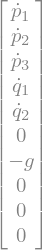

In [43]:
mod.f

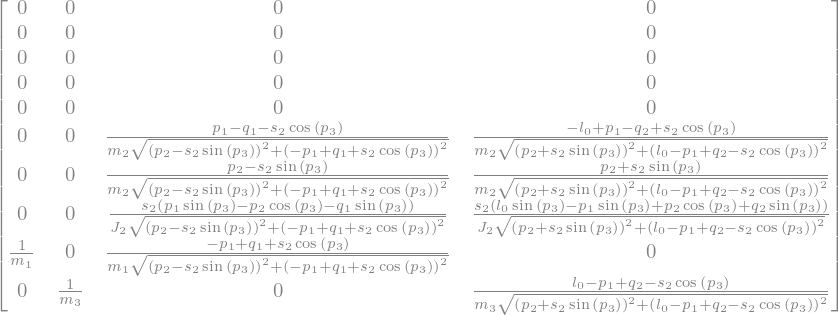

In [44]:
mod.g

In [45]:
used_params = []
for s in mod.eqns.s:
    if s not in [*ttheta, *tthetad, *tthetadd, *ttau]:
        used_params.append(s)

used_params.sort(key=str)
used_params ##:

---

In [46]:
num_params = [0.1, 9.81, 2, 10, 10, 10, 1]

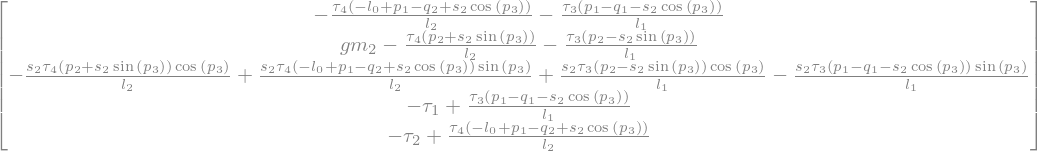

In [47]:
eqns.subz0(tthetadd)

---

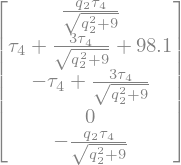

---

In [74]:
# determine a symetrical equilibrium:
# TODO: woher Wahl von ttau?
eqlbr_conditions = [(q1, 0), (p3, 0), (p1, 1), (p2, -3), (tau1, 0), (tau2, 0), (tau3, tau4)] ##:

res = ((mod.eqns.subz0(tthetadd)).subs(eqlbr_conditions)).subz(used_params, num_params) ##:

In [49]:
symbs = list(res.s) ##:
sol = sp.solve(res, symbs, dict=True)[0] ##:

---

---

In [50]:
ttheta0 = st.to_np(ttheta.subs(eqlbr_conditions).subs(sol)).squeeze() ##:

uu0 = st.to_np(ttau.subs(eqlbr_conditions).subs(sol)).squeeze()##:

ttheta0 := array([ 1., -3.,  0.,  0.,  0.])

---

uu0 := array([  0.  ,   0.  , -49.05, -49.05])

---

In [51]:
sim = st.SimulationModel(mod.f, mod.g, mod.xx, model_parameters=list(zip(used_params, num_params)))

In [52]:
# return a constant value for simplicity
uu1 = npy.array([  1.  ,   0.  , -49.05, -49.05])

def input_func(t):
    # constant input
    return uu1

rhs = sim.create_simfunction(input_function=input_func)

In [53]:
import numpy as npy
import scipy as sc
import scipy.integrate

In [54]:
xx0 = npy.concatenate((ttheta0, ttheta0*0)) ##:

xx0 := array([ 1., -3.,  0.,  0.,  0.,  0., -0.,  0.,  0.,  0.])

---

In [55]:
tt = npy.linspace(0, 10, 1000)

In [56]:
# solve_ivp is more modern, but the signature of rhs is taylored towards odeint
res = sc.integrate.odeint(rhs, xx0, tt) ##:i

info(res) := "<class 'numpy.ndarray'> with shape: (1000, 10)"

---

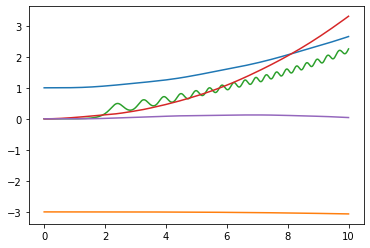

In [57]:
plt.plot(tt, res[:, :5])